In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import albumentations as A

In [2]:
np.random.seed(0)

In [3]:
import os

input_dir = "dataset/Training_Images"
target_dir = "dataset/Ground_Truth"
img_size = (256, 256)

X = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
y = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png")
    ]
)

print("Number of samples:", len(X))

Number of samples: 290


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=0)

print('Train length: ', len(X_train))
print('Validation length: ', len(X_val))
print('Test length: ', len(X_test))

Train length:  162
Validation length:  41
Test length:  87


In [5]:
transform = A.Compose([
    A.RandomRotate90(p=.3),
    A.RandomBrightnessContrast(p=.3),
    A.VerticalFlip(p=.3),
    A.HorizontalFlip(p=.3),
    A.ShiftScaleRotate(p=0.3)
])


In [6]:

from tensorflow.keras.preprocessing.image import load_img

class ImageLoader(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths, augment=False):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        self.augment = augment

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        y = np.zeros((self.batch_size,) + self.img_size, dtype="uint8")
        for j, (img_path, mask_path) in enumerate(zip(batch_input_img_paths, batch_target_img_paths)):
            img = load_img(img_path, target_size=self.img_size)
            mask = load_img(mask_path, target_size=self.img_size, color_mode="grayscale")
            if self.augment:
              transformed = transform(image=np.array(img), mask=np.array(mask))
              img, mask = transformed['image'], transformed['mask']
            x[j] = img
            y[j] = mask

        return x/255.0, y/255.0

In [7]:
train_batch_size = 16
test_batch_size = 32
train_gen = ImageLoader(train_batch_size, img_size, X_train, y_train, augment=False)
aug_train_gen = ImageLoader(train_batch_size, img_size, X_train, y_train, augment=True)
val_gen = ImageLoader(train_batch_size, img_size, X_val, y_val, augment=False)
test_gen = ImageLoader(test_batch_size, img_size, X_test, y_test, augment=False)


In [8]:
import matplotlib.pyplot as plt

def plot_samples(data_gen):
  fig, ax = plt.subplots(2, 5)
  fig.set_size_inches((12, 5))
  train_batch = data_gen.__getitem__(0)
  for i in range(5):
      ax[0, i].imshow(train_batch[0][i])
      ax[1, i].imshow(train_batch[1][i], cmap='gray')

      ax[0,i].axis("off")
      ax[1,i].axis("off")

  fig.tight_layout()
  plt.savefig('samples.pdf')
  plt.show()

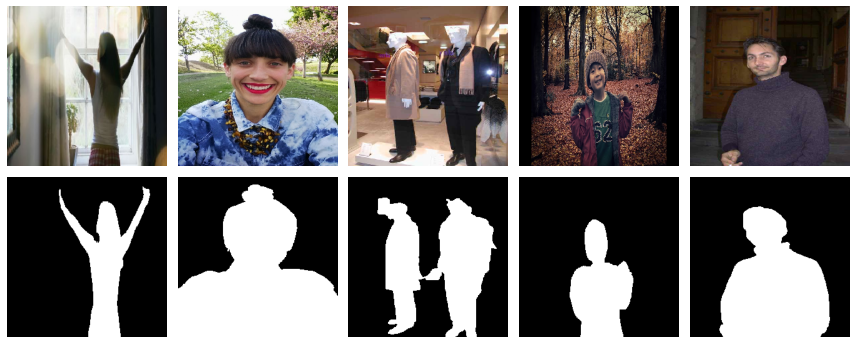

In [9]:
plot_samples(train_gen)

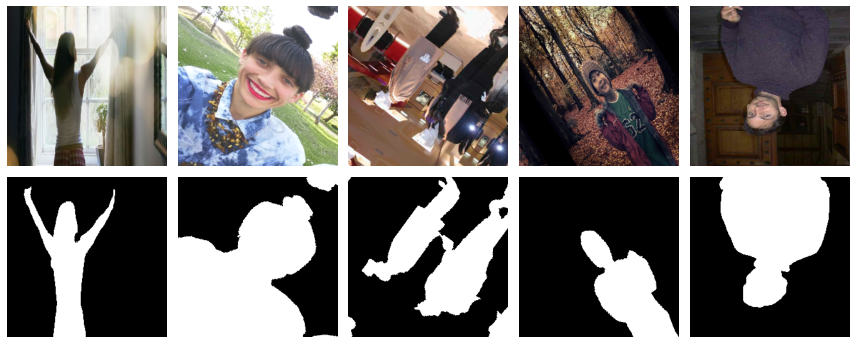

In [10]:
plot_samples(aug_train_gen)

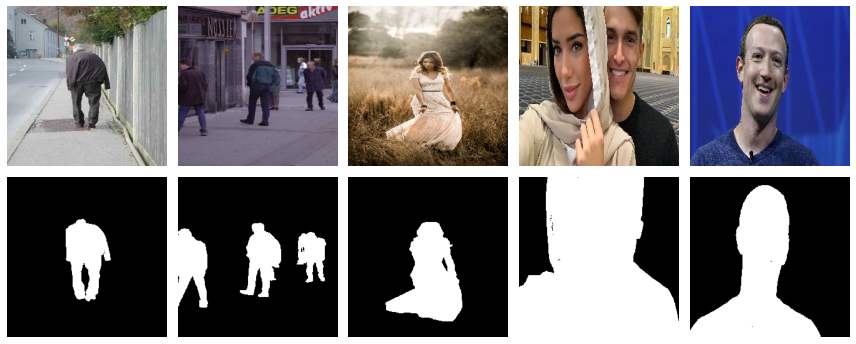

In [11]:
plot_samples(test_gen)

In [12]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate
from tensorflow.keras.models import Model

def build_model(name=None):
  inputs = Input(img_size + (3,))
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
  drop5 = Dropout(0.5)(conv5)

  up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

  up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

  up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

  up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

  unet = Model(inputs = inputs, outputs = conv10, name=f'UNet_{name}')

  return unet

In [13]:
models = {
  'base': build_model(name='base'),
  'aug': build_model(name='aug'),
  'es_aug': build_model(name='es_aug'),
}

2022-03-24 16:11:52.686570: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-24 16:11:53.043699: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38419 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:c1:00.0, compute capability: 8.0


In [14]:
for model in models.values():
  model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
reduce_lr1 = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=1e-6)
reduce_lr2 = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=1e-6)
reduce_lr3 = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=1e-6)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True, min_delta=0.01)

model_history = {
    'base': models['base'].fit(train_gen, validation_data=val_gen, epochs=100, callbacks=[reduce_lr1]),
    'aug': models['aug'].fit(aug_train_gen, validation_data=val_gen, epochs=100, callbacks=[reduce_lr2]),
    'es_aug': models['es_aug'].fit(aug_train_gen, validation_data=val_gen, epochs=100, callbacks=[reduce_lr3, early_stopping]),
}

Epoch 1/100


2022-03-24 16:11:55.751393: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200


10/10 [==============================] - 8s 198ms/step - loss: 0.6174 - accuracy: 0.7148 - val_loss: 0.5929 - val_accuracy: 0.7207 - lr: 1.0000e-04
Epoch 2/100
10/10 [==============================] - 1s 145ms/step - loss: 0.5999 - accuracy: 0.7166 - val_loss: 0.5804 - val_accuracy: 0.7207 - lr: 1.0000e-04
Epoch 3/100
10/10 [==============================] - 2s 147ms/step - loss: 0.5742 - accuracy: 0.7166 - val_loss: 0.5320 - val_accuracy: 0.7207 - lr: 1.0000e-04
Epoch 4/100
10/10 [==============================] - 1s 145ms/step - loss: 0.5331 - accuracy: 0.7166 - val_loss: 0.5011 - val_accuracy: 0.7207 - lr: 1.0000e-04
Epoch 5/100
10/10 [==============================] - 1s 144ms/step - loss: 0.5284 - accuracy: 0.7166 - val_loss: 0.5217 - val_accuracy: 0.7207 - lr: 1.0000e-04
Epoch 6/100
10/10 [==============================] - 1s 144ms/step - loss: 0.5081 - accuracy: 0.7166 - val_loss: 0.4893 - val_accuracy: 0.7207 - lr: 1.0000e-04
Epoch 7/100
10/10 [==============================] -

In [27]:
def plot_accuray(history, name):
  plt.figure(figsize=(6, 4))
  plt.title(f'{name} Model Accuracy')
  plt.plot(history.history['accuracy'], color='g', label='Train Accuracy')
  plt.plot(history.history['val_accuracy'], color='b', label='Val Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.savefig(f'{name}_accuracy.pdf')
  plt.show()

def plot_loss(history, name):
  plt.figure(figsize=(6, 4))
  plt.title(f'{name} Model Loss')
  plt.plot(history.history['loss'], color='g', label='Train Loss')
  plt.plot(history.history['val_loss'], color='b', label='Val Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Categorical Crossentropy Loss')
  plt.legend()
  plt.savefig(f'{name}_loss.pdf')
  plt.show()

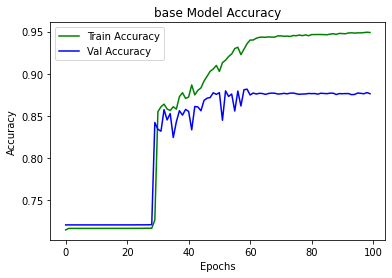

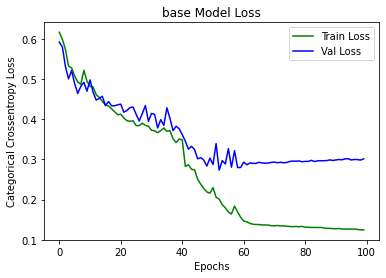

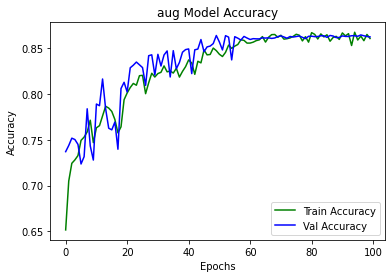

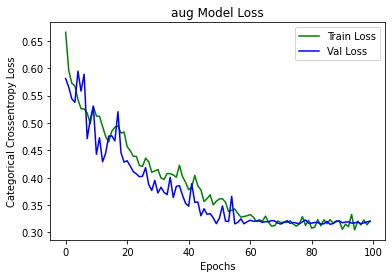

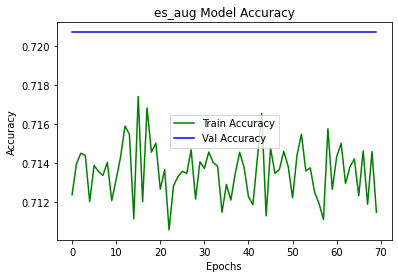

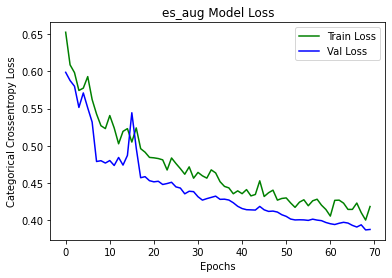

In [28]:
for name, history in model_history.items():
  plot_accuray(history, name)
  plot_loss(history, name)

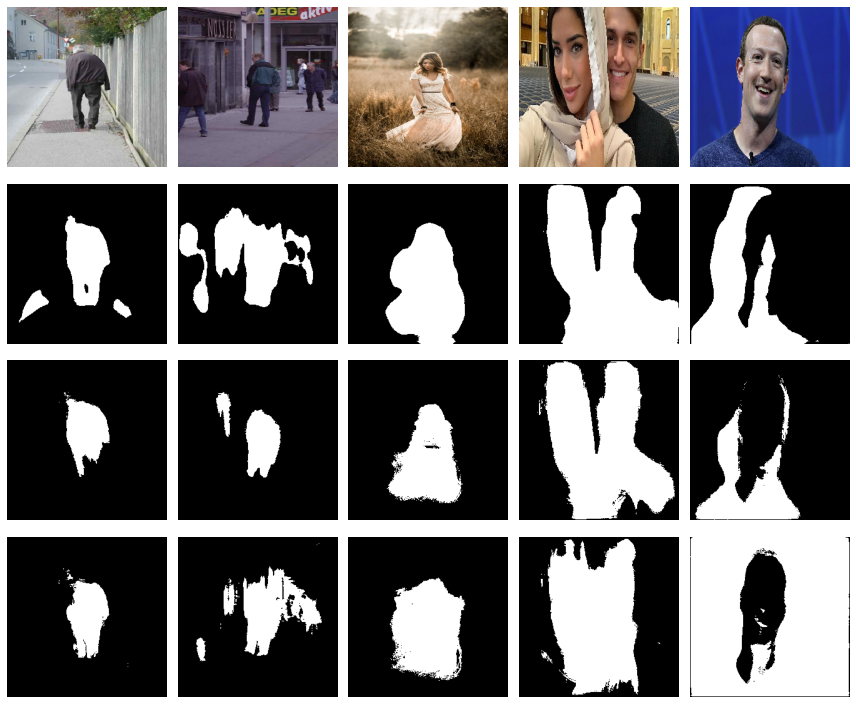

In [29]:
preds1 = models['base'].predict(test_gen) > 0.5
preds2 = models['aug'].predict(test_gen) > 0.5
preds3 = models['es_aug'].predict(test_gen) > 0.5

fig, ax = plt.subplots(4, 5)
fig.set_size_inches((12, 10))
test_batch = test_gen.__getitem__(0)
for i in range(5):
  ax[0, i].imshow(test_batch[0][i])
  ax[1, i].imshow(preds1[i].squeeze(), cmap='gray')
  ax[2, i].imshow(preds2[i].squeeze(), cmap='gray')
  ax[3, i].imshow(preds3[i].squeeze(), cmap='gray')

  ax[0,i].axis("off")
  ax[1,i].axis("off")
  ax[2,i].axis("off")
  ax[3,i].axis("off")
plt.savefig(f'preds.pdf')

fig.tight_layout()

In [30]:
for model in models.values():
  model.evaluate(test_gen)

2/2 [==============================] - 0s 120ms/step - loss: 0.3920 - accuracy: 0.8440
